In [1]:

import math
import random
import numpy as np
import random
from numpy.typing import NDArray
import pandas as pd
import itertools
import json
import time
from typing import List, Tuple, Deque, Optional, Callable
import gym_connect4
import gym
import torch
import collections
import torch.nn.init as init 
from tqdm.notebook import tqdm
import keras
import mcts
from torch.optim.lr_scheduler import _LRScheduler

/var/folders/cl/lzphfn455s34cpfk3wbjrvwm0000gn/T/ipykernel_60705/3557396154.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [26]:
keras.polic

AttributeError: module 'keras' has no attribute 'polic'

In [3]:
env = gym.make('Connect4-v0', height=6, width=9, connect=4)

In [ ]:
test = mcts.MCTSNode(keras.ActorCritic())

TypeError: __init__() missing 1 required positional argument: 'actor_critic'

In [24]:
##CROSS Entropy Training
#
#
#

#Setting up Objective Function Class

#Objective function, considering a "Best policy", objective function is given by the number of wins in 10 match vs the best policy 
#When switching to a policy, reset the training
#We train from a random policy vs random policy -> we get a policy 1 better than random policy

#We train from policies vs policy_n to get policy_n+1, objective function is playing vs policy_n
#Our policy is a neural network of the entry 
#How do we train ?
#Maybe we can do some DQN, he learns how to play against best_policy_n


#For DQN, we need some reward for every step (or I'm not sure it will converge)
#Hence, I saw we could do something called : https://gibberblot.github.io/rl-notes/single-agent/reward-shaping.html reward-shaping
#To give rewards even tho we have only rewards "at the end" when playing vs a policy
#The environment is Env + Adversary Agent, Learning to play both side, at the same time (using perception), we train with alternating roles


#Maybe 

class ObjectiveFunction:

    def __init__(self, env, policy,best_policy, num_episodes=1, max_time_steps=float('inf'), minimization_solver=True):
        self.ndim = policy.num_params  # Number of dimensions of the parameter (weights) space
        self.env = env
        self.policy = policy
        self.best_policy = best_policy
        self.num_episodes = num_episodes
        self.max_time_steps = max_time_steps
        self.minimization_solver = minimization_solver

        self.num_evals = 0


    def eval(self, policy_params, num_episodes=None, max_time_steps=None, render=False,win_threshold=0.7):
        """Evaluate a policy"""

        self.num_evals += 1
        if num_episodes is None:
            num_episodes = self.num_episodes

        if max_time_steps is None:
            max_time_steps = self.max_time_steps
        average_total_rewards = 0
        number_of_win = 0
      

        return average_total_rewards   # Optimizers do minimization by default...


    def __call__(self, policy_params, num_episodes=None, max_time_steps=None, render=False):
        return self.eval(policy_params, num_episodes, max_time_steps, render)

class QNetwork(torch.nn.Module):
    """
    A Q-Network implemented with PyTorch.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        First fully connected layer.
    layer2 : torch.nn.Linear
        Second fully connected layer.
    layer3 : torch.nn.Linear
        Third fully connected layer.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Define the forward pass of the QNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int, nn_l3=0, nn_l4=0, nn_l5 =0):
       
        if(nn_l3 == 0):
            nn_l3 = nn_l2
        if(nn_l4 == 0):
           nn_l4 = nn_l3 
        if(nn_l5 == 0):
           nn_l5 = nn_l4

        #How to do Network ? Send every line and every column to differnet layers?
        super(QNetwork, self).__init__()

        self.layer1 = torch.nn.Conv1d(1, nn_l1,kernel_size=5)
        self.layer2 = torch.nn.Conv1d(nn_l1, nn_l2,kernel_size=5,padding=2)
        self.layer3 = torch.nn.Conv1d(nn_l2, nn_l3,kernel_size=5,padding=2)
        self.layer4 = torch.nn.Conv1d(nn_l3, nn_l4,kernel_size=5,padding=2)
        self.layer5 = torch.nn.Linear(nn_l4, nn_l5)
        self.layer6 = torch.nn.Linear(nn_l5, n_actions)
        self.leaky_relu = torch.nn.LeakyReLU()

        init.xavier_uniform_(self.layer1.weight)
        init.xavier_uniform_(self.layer2.weight)
        init.xavier_uniform_(self.layer3.weight)
        init.xavier_uniform_(self.layer4.weight)
        init.xavier_uniform_(self.layer5.weight)
        init.xavier_uniform_(self.layer6.weight)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the QNetwork.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor (state).

        Returns
        -------
        torch.Tensor
            The output tensor (Q-values).
        """
        
        x = x.to(self.layer1.weight.dtype)
        x = self.leaky_relu(self.layer1(x))
        x = self.leaky_relu(self.layer2(x))
        x = self.leaky_relu(self.layer3(x))
        x = self.leaky_relu(self.layer4(x))
        x = self.leaky_relu(self.layer5(x))
        x = self.layer6(x)

        return x
class Policy:
    
    def __init__(self, env,epsilon=0.5,epsilon_min=0.013, epsilon_decay=0.9875):
        self.number_inputs = env.width * env.height #Size of observation grid 
        self.number_actions = env.width 
        self.qnetwork = QNetwork(self.number_inputs, env.width, env.height, self.number_actions)
        self.epsilon = epsilon
        self.env = env
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        #A policy is a QNetwork, that tries to guess what to play according to state 
        #Returns a probability to play each action
    
    def __call__(self,state,no_epsilon = False):
        available_moves = self.env.get_moves()
        q_values = self.qnetwork(torch.tensor(state)) #Get possible values
       
        if(random.random()<self.epsilon and not no_epsilon):
            action = random.choice(available_moves)
          
            #Play random move
        else:
            best_move = available_moves[0]
            best_q_value = q_values[best_move]
            for move in available_moves:
                if(q_values[move]>best_q_value):
                    best_move = move 
                    best_q_value = q_values[move]
            action = best_move

        return action 
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def reset_epsilon(self, epsilon = 0.5):
        self.epsilon = epsilon


class MCTSPolicy(Policy):
    def __init__(self, env,epsilon=0.5,epsilon_min=0.013, epsilon_decay=0.9675):
        self.number_inputs = env.width * env.height #Size of observation grid 
        self.number_actions = env.width 
        self.epsilon = epsilon
        self.env = env
        self.final_action = None
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.state = np.asarray([0 for i in range(env.width*env.height)])
        self.tree = {self.root_node:{'state':self.state, 'player':self.player,
                              'child':[], 'parent': None, 'total_node_visits':0,
                              'total_node_wins':0}}
        self.total_parent_node_visits = 0
        self.tunable_constant = 1.0

    def get_ucb(self, node_no):
      if not self.total_parent_node_visits:
        return math.inf
      else:
        value_estimate = self.tree[node_no]['total_node_wins'] / (self.tree[node_no]['total_node_visits'] + 1)
        exploration = math.sqrt(2*math.log(self.total_parent_node_visits) / (self.tree[node_no]['total_node_visits'] + 1))
        ucb_score =  value_estimate + self.tunable_constant * exploration
        return ucb_score
      
    def selection(self):
      '''
      Aim - To select the leaf node with the maximum UCB
      '''
      is_terminal_state = False
      leaf_node_id = (0,)
      while not is_terminal_state:
        node_id = leaf_node_id
        number_of_child = len(self.tree[node_id]['child'])
        if not number_of_child:
          leaf_node_id = node_id
          is_terminal_state = True
        else:
          max_ucb_score = -math.inf
          best_action = leaf_node_id
          for i in range(number_of_child):
            action = self.tree[node_id]['child'][i]
            child_id = leaf_node_id + (action,)
            current_ucb = self.get_ucb(child_id)
            if current_ucb > max_ucb_score:
              max_ucb_score = current_ucb
              best_action = action
          leaf_node_id = leaf_node_id + (best_action,)
      return leaf_node_id
    

    def expansion(self, leaf_node_id):
      '''
      Aim - Add new nodes to the current leaf node by taking a random action
            and then take a random or follow any policy to take opponent's action.
      '''
      current_state = self.tree[leaf_node_id]['state']
      player_mark = self.tree[leaf_node_id]['player']
      current_board = np.asarray(current_state).reshape(self.env.width*self.env.height)
      self.actions_available = [c for c in range(self.config.columns) if not current_board[c]]
      done = check_result(current_state, player_mark, self.config)
      child_node_id = leaf_node_id
      is_availaible = False

      if len(self.actions_available) and not done:
        childs = []
        for action in self.actions_available:
          child_id = leaf_node_id + (action,)
          childs.append(action)
          new_board = put_new_piece(current_state, action, player_mark, self.config)
          self.tree[child_id] = {'state': new_board, 'player': player_mark,
                                 'child': [], 'parent': leaf_node_id,
                                 'total_node_visits':0, 'total_node_wins':0}

          if check_result(new_board, player_mark, self.config):
            best_action = action
            is_availaible = True

        self.tree[leaf_node_id]['child'] = childs
        
        if is_availaible:
          child_node_id = best_action
        else:
          child_node_id = random.choice(childs)

      return leaf_node_id + (child_node_id,)

    def __call__(self,state):
        available_moves = self.env.get_moves()
        q_values = self.qnetwork(torch.tensor(state)) #Get possible values
        
        if(random.random()<self.epsilon):
            action = random.choice(available_moves)
            #Play random move
        else:
            best_move = available_moves[0]
            best_q_value = q_values[best_move]
            for move in available_moves:
                if(q_values[move]>best_q_value):
                    best_move = move 
                    best_q_value = q_values[move]
            action = best_move
#A completer quand on aura pas la flemme 
            
def better_step(env,action,player):
        observed_space, reward_vector,winner,info = env.step(action)
        states = observed_space[player]
        empty_states = states[0]
        player_states = states[1]
        opponent_states = states[2]
        done = winner or (len(info['legal_actions'])==0)
        trad_state = player_states - opponent_states
        return trad_state.flatten(), reward_vector[player],done

In [5]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

In [ ]:
#Naive training
def train_naive_agent_against(env: gym.Env,
                      optimizer: torch.optim.Optimizer,
                      first_agent: Policy,
                      oponnent:Policy,
                      loss_fn: Callable,
                      device: torch.device,
                      lr_scheduler: _LRScheduler,
                      num_episodes: int,
                      gamma: float) -> List[float]:
    

    """
    Train the Q-network on the given environment.

    Parameters
    ----------
    env : gym.Env
        The environment to train on.
    q_network : torch.nn.Module
        The Q-network to train.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : callable
        The loss function to use for training.
    epsilon_greedy : EpsilonGreedy
        The epsilon-greedy policy to use for action selection.
    device : torch.device
        The device to use for PyTorch computations.
    lr_scheduler : torch.optim.lr_scheduler._LRScheduler
        The learning rate scheduler to adjust the learning rate during training.
    num_episodes : int
        The number of episodes to train for.
    gamma : float
        The discount factor for future rewards.

    Returns
    -------
    List[float]
        A list of cumulated rewards per episode.
    """
    trainee_wins=  0
    trainer_wins = 0
    episode_reward_list = []
    
    player = 0 
    for episode_index in tqdm(range(1, num_episodes)):
        state = env.reset()
        state= state[0][1].flatten()
        episode_reward = 0
        player = np.random.choice([0,1])
      
        if(player ==1):
            opponent_action = oponnent.__call__(state)
            state, _= better_step(env, opponent_action,player)
        
        for t in itertools.count():
            q_network = first_agent.qnetwork
            q_values = q_network(torch.tensor(state))
            
            #Play a move from agent
            action = first_agent.__call__(state)
            # Take the action in the environment
            calculated_reward = 0
            if(len(env.get_moves()) == 0):#Can't play, it is a draw
                done = True 
            else:#Can play
                next_state, done = better_step(env,action,1-player)#Return it as visualized by opponent
                if(done):#Played a winning move, end of game 
                    calculated_reward = 1

                    trainee_wins +=1
                else:#Enemy's turn 
                    if(len(env.get_moves()) == 0):#Enemy can't play, it is a draw 
                        done = True 
                    else:#Enemy plays
                        opponent_action = oponnent.__call__(next_state)
                        next_state, done = better_step(env, opponent_action,player)
                        if(done):#Enemy played a winning move, end of game
                            calculated_reward = -1
                            trainer_wins +=1
                            
                       
                            
            episode_reward += calculated_reward
            next_state_tensor = torch.tensor(next_state)
            with torch.no_grad():
                target_q_values = calculated_reward + gamma * torch.max(q_network(next_state_tensor))
            current_q_value = q_values[action]
            
            loss = loss_fn(current_q_value, target_q_values)
            # Zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if done:
                break

            # Move to the next state
            state = next_state

        episode_reward_list.append(episode_reward)
        first_agent.decay_epsilon()
        lr_scheduler.step()

        
    print("End of episode: Trainer winrate : {:.2f}%, Trainee winrate : {:.2f}%, Draw rate : {:.2f}%".format(100* (trainer_wins/num_episodes), 100* (trainee_wins/num_episodes), 100* ((num_episodes -trainee_wins-trainer_wins)/num_episodes)))
    return episode_reward_list

In [7]:
#Adding Replay Buffer
import random
class ReplayBuffer:
    """
    A Replay Buffer.

    Attributes
    ----------
    buffer : collections.deque
        A double-ended queue where the transitions are stored.

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    __len__()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        """
        self.capacity = capacity
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool):
        """
        Add a new transition to the buffer.

        Parameters
        ----------
        state : np.ndarray
            The state vector of the added transition.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : np.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        """
        if(self.__len__() >self.capacity):
            self.buffer = collections.deque(maxlen=capacity)
            self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[np.ndarray, float, float, np.ndarray, bool]
            A batch of `batch_size` transitions.
        """
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

In [9]:
def train_dqn1_agent(env: gym.Env,
                     first_agent:Policy,
                     oponnent:Policy,
                     optimizer: torch.optim.Optimizer,
                     loss_fn: Callable,
                     device: torch.device,
                     lr_scheduler: _LRScheduler,
                     num_episodes: int,
                     gamma: float,
                     batch_size: int,
                     replay_buffer: ReplayBuffer,
                     render:bool) -> List[float]:
  
    episode_reward_list = []
    q_network = first_agent.qnetwork
    player = 0
    for episode_index in range(1, num_episodes):
        state= env.reset()
        state = state[0][1].flatten()
        
        episode_reward = 0
        player = np.random.choice([0,1])
        if(player == 1):
            opponent_action = oponnent.__call__(state)
            state, reward, done = better_step(env, opponent_action,player)
        for t in itertools.count():

            

            
            if(len(env.get_moves())==0):
                done = True 
                reward = 0 
            else:
                action = first_agent.__call__(state)
                next_state, done, reward = better_step(env, action, 1-player)
                if(not done and len(env.get_moves()) !=0):
                    opponent_action = oponnent.__call__(next_state)
                    next_state, reward,done = better_step(env, opponent_action, player)
                    reward = -1*reward
              
            
            replay_buffer.add(state, action, reward, next_state, done)

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                states = torch.tensor(states, device=device)
                actions = torch.tensor(actions,  device=device)
                rewards = torch.tensor(rewards, device=device)
                next_states = torch.tensor(next_states,  device=device)
                dones = torch.tensor(dones,device=device)
                q_network= first_agent.qnetwork
                q_values = q_network(states)
                next_q_values = q_network(next_states)
                target_q_values = rewards + gamma * torch.max(next_q_values, dim=1).values * ~dones

                loss = loss_fn(q_values.gather(1, actions.unsqueeze(1)), target_q_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                lr_scheduler.step()

            if done:
                break

            state = next_state
            episode_reward += reward

        episode_reward_list.append(episode_reward)
        first_agent.decay_epsilon()

    return episode_reward_list

<h1> Training with DQN - not Naive function </h1>

In [ ]:
number_of_training_done = 0

In [ ]:
number_of_training_done

7

Tuple(Discrete(7), Discrete(7))

In [25]:
env = gym.make('Connect4-v0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA if available, otherwise use CPU
NUMBER_OF_TRAININGS = 1000
naive_trains_result_list = [[], [], []]

first_agent = 1
opponent_agent = 2

first_agent = Policy(env)
#first_agent.qnetwork = torch.load("network_3.pth")
#Raw neural network
opponent_agent = Policy(env)
for train_index in tqdm(range(NUMBER_OF_TRAININGS)):

    optimizer = torch.optim.AdamW(first_agent.qnetwork.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()
    replay_buffer = ReplayBuffer(2000)
    first_agent.epsilon = 0.9
    episode_reward_list = train_dqn1_agent(env,
                                            first_agent,
                                            opponent_agent,
                                            optimizer,
                                            loss_fn,
                                            device,
                                            lr_scheduler,
                                            num_episodes=200,
                                            gamma=0.9,
                                            replay_buffer=replay_buffer,
                                            batch_size=128,
                                            render=False
                            
                                            )
    naive_trains_result_list[0].extend(range(len(episode_reward_list)))
    naive_trains_result_list[1].extend(episode_reward_list)
    naive_trains_result_list[2].extend([train_index for _ in episode_reward_list])

    if(train_index % 10 == 0):
            opponent_agent = 2 
            opponent_agent = Policy(env)
            opponent_agent.qnetwork.load_state_dict(first_agent.qnetwork.state_dict()) #Load opponent as trained one
naive_trains_result_df = pd.DataFrame(np.array(naive_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
naive_trains_result_df["agent"] = "Naive"

# Save the action-value estimation function of the last train

torch.save(first_agent.qnetwork, "network_"+str(number_of_training_done)+".pth")

number_of_training_done+=1
env.close()






  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [42]

In [ ]:
torch.save(Agent_1.qnetwork, "network_bis_"+str(number_of_training_done)+".pth")

<h1> Testing two Agent in 1vs1 </h1> 
<h2> Agent 1 (Policy) with or without epsilon
<h2> Agent 2 (Policy) with or without epsilon

In [12]:
Agent_1 = 1
Agent_2 = 1

In [13]:
Agent_1 = Policy(env)
Agent_1.qnetwork = torch.load("network_6.pth")#
Agent_2 = Policy(env)

no_epsilon_1 = False #True if games are played without epsilon policy
no_epsilon_2 = False #if games are played withotu epsilon policy

TypeError: __init__() missing 1 required positional argument: 'kernel_size'

In [30]:
#With training during play
optimizer = torch.optim.AdamW(Agent_1.qnetwork.parameters(), lr=0.004, amsgrad=True)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()
def play_a_game(env, first_agent, oponnent, no_epsilon_1 = False, no_epsilon_2 = False,render=False):
        state = env.reset()
        state= state[0][1].flatten()
        episode_reward = 0
        player = np.random.choice([0,1])
       
        
        if(player ==1):
            opponent_action = oponnent.__call__(state, no_epsilon_2)
            state, _,_= better_step(env, opponent_action,player)
            
            if(render): env.render()
            
        for t in itertools.count():
            q_network = first_agent.qnetwork
            q_values = q_network(torch.tensor(state))
            
            #Play a move from agent
            action = first_agent.__call__(state, no_epsilon=no_epsilon_1)
            # Take the action in the environment
            calculated_reward = 0
            if(len(env.get_moves()) == 0):#Can't play, it is a draw
                done = True 
                
            else:#Can play
               
                next_state,_, done = better_step(env,action,1-player)#Return it as visualized by opponent
                if(render): env.render()
                if(done):#Played a winning move, end of game 
                    calculated_reward = 1
                  
                else:#Enemy's turn 
                    if(len(env.get_moves()) == 0):#Enemy can't play, it is a draw 
                        done = True 
                        
                    else:#Enemy plays
                      
                        opponent_action = oponnent.__call__(next_state,no_epsilon=no_epsilon_2)
                        next_state, _,done = better_step(env, opponent_action,player)
                     
                        if(render): env.render()
                        if(done):#Enemy played a winning move, end of game
                            calculated_reward = -1
                           
                            
                       
                            
            episode_reward += calculated_reward
            next_state_tensor = torch.tensor(next_state)
            

            if done:
                break

            # Move to the next state
            state = next_state
        return calculated_reward
def play_a_game_with_train(env, first_agent, oponnent,optimizer, loss, gamma, lr_scheduler,render=False,replay_buffer = ReplayBuffer(2000),batch_size=128):
        state = env.reset()
        state= state[0][1].flatten()
        episode_reward = 0
        player = np.random.choice([0,1])
        if(render):env.render()
        
        if(player ==1):
            opponent_action = oponnent.__call__(state)
            state, _,_= better_step(env, opponent_action,player)
        
            if(render):env.render()
        for t in itertools.count():
            q_network = first_agent.qnetwork
            q_values = q_network(torch.tensor(state))
            
            #Play a move from agent
            action = first_agent.__call__(state)
            # Take the action in the environment
            calculated_reward = 0
            if(len(env.get_moves()) == 0):#Can't play, it is a draw
                done = True 
            else:#Can play
                next_state, _,done = better_step(env,action,1-player)#Return it as visualized by opponent
                if(render):env.render()
                if(done):#Played a winning move, end of game 
                    calculated_reward = 1 
                else:#Enemy's turn 
                    if(len(env.get_moves()) == 0):#Enemy can't play, it is a draw 
                        done = True  
                    else:#Enemy plays
                        opponent_action = oponnent.__call__(next_state)
                        next_state, _,done = better_step(env, opponent_action,player)
                        if(render):env.render()
                        if(done):#Enemy played a winning move, end of game
                            calculated_reward = -1             
            episode_reward += calculated_reward
            next_state_tensor = torch.tensor(next_state)
            
            next_state_tensor = torch.tensor(next_state)

            replay_buffer.add(state, action, calculated_reward, next_state, done)

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                states = torch.tensor(states, device=device)
                actions = torch.tensor(actions,  device=device)
                rewards = torch.tensor(rewards, device=device)
                next_states = torch.tensor(next_states,  device=device)
                dones = torch.tensor(dones,device=device)
                q_network= first_agent.qnetwork
                q_values = q_network(states)
                next_q_values = q_network(next_states)
                target_q_values = rewards + gamma * torch.max(next_q_values, dim=1).values * ~dones

                loss = loss_fn(q_values.gather(1, actions.unsqueeze(1)), target_q_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                lr_scheduler.step()


            #with torch.no_grad():
               # target_q_values = calculated_reward + gamma * torch.max(q_network(next_state_tensor))
            #current_q_value = q_values[action]
            
            #loss = loss_fn(current_q_value, target_q_values)
            # Zero gradients, perform a backward pass, and update the weights
            #optimizer.zero_grad()
            #loss.backward()
            #optimizer.step()
            if done:
                break
            state = next_state
        
        first_agent.decay_epsilon()
        lr_scheduler.step()
        return calculated_reward
NUMBER_OF_GAMES = 1000
agent_wins = 0
opponent_wins = 0
draws = 0
for i in tqdm(range(NUMBER_OF_GAMES)):
    #res = play_a_game_with_train(env, Agent_1, Agent_2,optimizer, loss_fn,0.5,lr_scheduler)
    res = play_a_game(env, Agent_1, Agent_2, no_epsilon_1, no_epsilon_2)
    if(res == 1):
        agent_wins+=1
    elif(res ==-1):
        opponent_wins +=1
    else:
        draws+=1
print("Result without training")
print(agent_wins, opponent_wins, draws)
agent_wins = 0
opponent_wins = 0
draws = 0
wr = 1
wrs = []
for i in tqdm(range(NUMBER_OF_GAMES)):
    res = play_a_game_with_train(env, Agent_1, Agent_2,optimizer, loss_fn,0.5,lr_scheduler,1)
    #res = play_a_game(env, Agent_1, Agent_2, False, False)
    if(res == 1):
        agent_wins+=1
        wr = (wr*i + 1)/(i+1)
        wrs.append(wr)
    elif(res ==-1):
        opponent_wins +=1
        wr = (wr*i)/(i+1)
        wrs.append(wr)
    else:
        draws+=1 
print("Result with a training")
print(agent_wins, opponent_wins, draws)


  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: Input type (long long) and bias type (float) should be the same

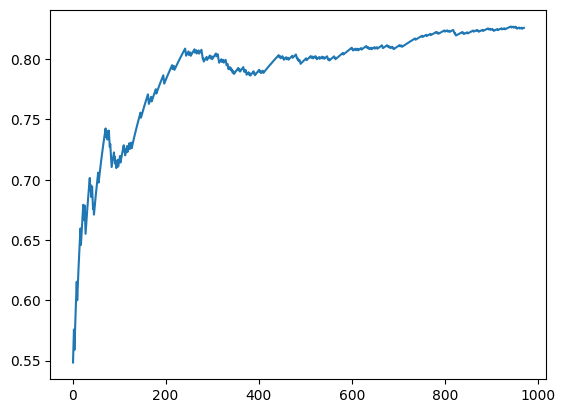

In [ ]:
import matplotlib.pyplot as plt 
wrs = wrs[15:]
plt.plot(np.linspace(1,len(wrs), len(wrs)),wrs)
plt.show()

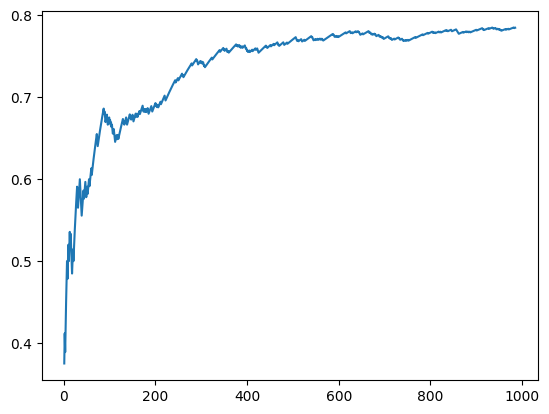

In [ ]:
import matplotlib.pyplot as plt 
wrs = wrs[15:]
plt.plot(np.linspace(1,len(wrs), len(wrs)),wrs)
plt.show()

In [ ]:
Agent_1 = Policy(env)
results_w = []
results_wo = []
#Agent_1.qnetwork = torch.load("network_5.pth")
number_of_training = 10000
Agent_2 = Policy(env)
replay_buffer = ReplayBuffer(2000)
for i in tqdm(range(number_of_training)):
    if(i%50 == 0):
        Agent_2.qnetwork.load_state_dict(Agent_1.qnetwork.state_dict())

    no_epsilon_1 = True #True if games are played without epsilon policy
    no_epsilon_2 = True #True if games are played withotu epsilon policy

    #With training during play
    optimizer = torch.optim.AdamW(Agent_1.qnetwork.parameters(), lr=0.004, amsgrad=True)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()
    def play_a_game(env, first_agent, oponnent, no_epsilon_1 = False, no_epsilon_2 = False,render=False):
            state = env.reset()
            state= state[0][1].flatten()
            episode_reward = 0
            player = np.random.choice([0,1])
        
            
            if(player ==1):
                opponent_action = oponnent.__call__(state, no_epsilon_2)
                state, _,_= better_step(env, opponent_action,player)
                
                if(render): env.render()
                
            for t in itertools.count():
                q_network = first_agent.qnetwork
                q_values = q_network(torch.tensor(state))
                
                #Play a move from agent
                action = first_agent.__call__(state, no_epsilon_1)
                # Take the action in the environment
                calculated_reward = 0
                if(len(env.get_moves()) == 0):#Can't play, it is a draw
                    done = True 
                    
                else:#Can play
                
                    next_state, done,_ = better_step(env,action,1-player)#Return it as visualized by opponent
                    if(render): env.render()
                    if(done):#Played a winning move, end of game 
                        calculated_reward = 1
                    
                    else:#Enemy's turn 
                        if(len(env.get_moves()) == 0):#Enemy can't play, it is a draw 
                            done = True 
                            
                        else:#Enemy plays
                        
                            opponent_action = oponnent.__call__(next_state,no_epsilon_2)
                            next_state, done,_ = better_step(env, opponent_action,player)
                        
                            if(render): env.render()
                            if(done):#Enemy played a winning move, end of game
                                calculated_reward = -1
                            
                                
                        
                                
                episode_reward += calculated_reward
                next_state_tensor = torch.tensor(next_state)
                

                if done:
                    break

                # Move to the next state
                state = next_state
            return calculated_reward
    def play_a_game_with_train(env, first_agent, oponnent,optimizer, loss, gamma, lr_scheduler,render=False,replay_buffer = ReplayBuffer(2000)):
            state = env.reset()
            state= state[0][1].flatten()
            episode_reward = 0
            player = np.random.choice([0,1])
            if(render):env.render()
            
            if(player ==1):
                opponent_action = oponnent.__call__(state)
                state, _,_= better_step(env, opponent_action,player)
            
                if(render):env.render()
            for t in itertools.count():
                q_network = first_agent.qnetwork
                q_values = q_network(torch.tensor(state))
                
                #Play a move from agent
                action = first_agent.__call__(state)
                # Take the action in the environment
                calculated_reward = 0
                if(len(env.get_moves()) == 0):#Can't play, it is a draw
                    done = True 
                else:#Can play
                    next_state, done,_ = better_step(env,action,1-player)#Return it as visualized by opponent
                    if(render):env.render()
                    if(done):#Played a winning move, end of game 
                        calculated_reward = 1 
                    else:#Enemy's turn 
                        if(len(env.get_moves()) == 0):#Enemy can't play, it is a draw 
                            done = True  
                        else:#Enemy plays
                            opponent_action = oponnent.__call__(next_state)
                            next_state, done,_ = better_step(env, opponent_action,player)
                            if(render):env.render()
                            if(done):#Enemy played a winning move, end of game
                                calculated_reward = -1             
                episode_reward += calculated_reward
                next_state_tensor = torch.tensor(next_state)
                
                next_state_tensor = torch.tensor(next_state)

                replay_buffer.add(state, action, calculated_reward, next_state, done)

                if len(replay_buffer) >= 32:
                    states, actions, rewards, next_states, dones = replay_buffer.sample(32)

                    states = torch.tensor(states, device=device)
                    actions = torch.tensor(actions,  device=device)
                    rewards = torch.tensor(rewards, device=device)
                    next_states = torch.tensor(next_states,  device=device)
                    dones = torch.tensor(dones,device=device)
                    q_network= first_agent.qnetwork
                    q_values = q_network(states)
                    next_q_values = q_network(next_states)
                    target_q_values = rewards + gamma * torch.max(next_q_values, dim=1).values * ~dones

                    loss = loss_fn(q_values.gather(1, actions.unsqueeze(1)), target_q_values.unsqueeze(1))

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    lr_scheduler.step()


                #with torch.no_grad():
                # target_q_values = calculated_reward + gamma * torch.max(q_network(next_state_tensor))
                #current_q_value = q_values[action]
                
                #loss = loss_fn(current_q_value, target_q_values)
                # Zero gradients, perform a backward pass, and update the weights
                #optimizer.zero_grad()
                #loss.backward()
                #optimizer.step()
                if done:
                    break
                state = next_state
            
            first_agent.decay_epsilon()
            lr_scheduler.step()
            return calculated_reward
    NUMBER_OF_GAMES_test = 100
    agent_wins = 0
    opponent_wins = 0
    draws = 0
    for i in tqdm(range(NUMBER_OF_GAMES_test)):
        #res = play_a_game_with_train(env, Agent_1, Agent_2,optimizer, loss_fn,0.5,lr_scheduler)
        res = play_a_game(env, Agent_1, Agent_2, no_epsilon_1, no_epsilon_2)
        if(res == 1):
            agent_wins+=1
        elif(res ==-1):
            opponent_wins +=1
        else:
            draws+=1
    print("Result without training")
    print(agent_wins, opponent_wins, draws)
    results_wo.append(agent_wins/NUMBER_OF_GAMES_test)

    agent_wins = 0
    opponent_wins = 0
    draws = 0
    NUMBER_OF_GAMES = 200
    for i in tqdm(range(NUMBER_OF_GAMES)):
        res = play_a_game_with_train(env, Agent_1, Agent_2,optimizer, loss_fn,0.5,lr_scheduler)
        #res = play_a_game(env, Agent_1, Agent_2, False, False)
        if(res == 1):
            agent_wins+=1
        elif(res ==-1):
            opponent_wins +=1
        else:
            draws+=1        
    print("Result with a training")
    print(agent_wins, opponent_wins, draws)
    results_w.append(agent_wins/NUMBER_OF_GAMES)

    torch.save(first_agent.qnetwork, "night_trainedk_"+str(number_of_training_done)+".pth")

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Result without training
53 47 0


  0%|          | 0/200 [00:00<?, ?it/s]

/Users/enzo/miniconda3/envs/RLEnv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


IndexError: list index out of range

<Axes: >

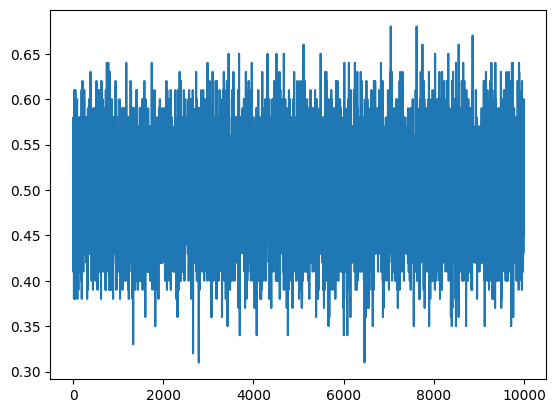

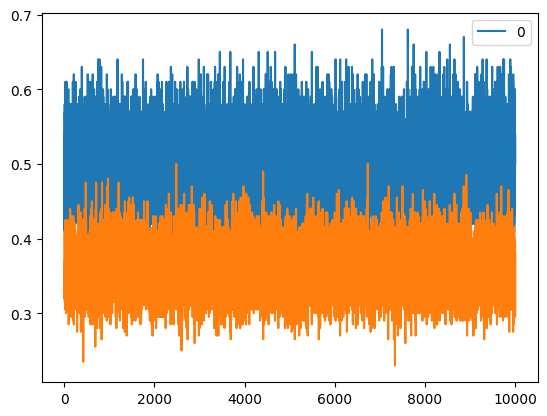

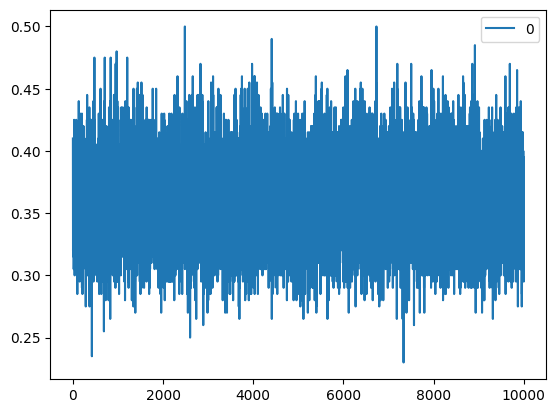

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(results_wo))],results_wo)
x = pd.DataFrame(results_wo)
x.plot()
plt.plot([i for i in range(len(results_w))],results_w)
x = pd.DataFrame(results_w)
x.plot()

In [ ]:
results_wo

[0.5,
 0.46,
 0.53,
 0.42,
 1.0,
 1.0,
 0.49,
 1.0,
 0.57,
 0.41,
 0.45,
 0.6,
 1.0,
 1.0,
 1.0,
 0.47,
 1.0,
 1.0,
 1.0,
 1.0,
 0.53,
 1.0,
 1.0,
 0.52,
 1.0,
 0.45,
 0.48,
 0.55,
 1.0,
 0.49,
 0.46,
 0.51,
 1.0,
 1.0,
 0.45,
 0.48,
 0.48,
 0.58,
 0.49,
 1.0,
 0.55,
 1.0,
 0.53,
 0.42,
 0.49,
 0.54,
 0.53,
 0.47,
 0.47,
 0.45,
 0.53,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.54,
 1.0,
 1.0,
 0.59,
 1.0,
 0.46,
 1.0,
 0.4,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.5,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.54,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.53,
 1.0,
 1.0,
 1.0,
 1.0,
 0.44]

<h1> Checking Inside an Agent </h1>

In [ ]:
first_agent = Agent_1
for name, param in first_agent.qnetwork.named_parameters():
    if 'weight' in name:  # Check if the parameter is a weight parameter
        print(f'Layer: {name}, Coefficients:')
        print(param.data)
        print()

Layer: layer1.weight, Coefficients:
tensor([[-0.1470, -0.0872, -0.1155,  0.3261,  0.0190,  0.2062,  0.3024, -0.0319,
         -0.0266,  0.2604,  0.3484,  0.2337,  0.1171, -0.0648, -0.3295, -0.3023,
         -0.2565,  0.0757, -0.1950, -0.0112,  0.2901, -0.3007, -0.3056, -0.0866,
         -0.2704,  0.0962,  0.0921,  0.3258,  0.0520, -0.2255, -0.2958,  0.3215,
          0.2063, -0.2428, -0.2269,  0.1836,  0.3181, -0.0320,  0.0744,  0.1923,
         -0.1092,  0.1624],
        [-0.0700, -0.2239, -0.2686, -0.0645, -0.1046, -0.2412,  0.1805,  0.1030,
          0.0825,  0.0155, -0.1741, -0.1700,  0.0606,  0.2257, -0.3149, -0.0228,
          0.0437, -0.1717, -0.2697,  0.2755,  0.1242, -0.1064,  0.0655,  0.1838,
          0.2859, -0.0422,  0.2047, -0.2051, -0.2031, -0.0469, -0.0712, -0.0805,
          0.3419,  0.2792, -0.1474,  0.3302, -0.0371,  0.1903,  0.1039, -0.0355,
         -0.1586,  0.0139],
        [-0.3173,  0.1352,  0.0869,  0.3252,  0.1879,  0.2998, -0.2836,  0.2166,
          0.0155,

In [ ]:
opponent = Agent_2

for name, param in opponent.qnetwork.named_parameters():
    if 'weight' in name:  # Check if the parameter is a weight parameter
        print(f'Layer: {name}, Coefficients:')
        print(param.data)
        print()

Layer: layer1.weight, Coefficients:
tensor([[ 3.1140e-02,  1.7326e-01,  5.6380e-01,  1.5365e-01, -3.9464e-02,
         -1.0814e-01,  1.0639e-01, -4.3569e-02,  2.7794e-03, -1.8147e-01,
         -4.4861e-02, -2.4894e-01, -4.5480e-02, -2.1024e-02, -1.2339e-01,
         -1.1777e-01,  1.3028e-01,  6.3124e-02,  1.1721e-01,  1.4864e-01,
          4.4648e-01,  4.3444e-01, -5.1315e-02,  5.5595e-02, -9.5817e-02,
         -2.2934e-01, -1.4623e-01, -1.0727e+00,  1.6371e-01,  1.0326e-01,
          1.1433e-01,  1.6620e-01,  1.8845e-01,  6.7479e-01,  2.2610e-01,
          2.6910e-01,  1.2901e-01, -7.9494e-02, -1.4956e-01, -1.3752e-02,
          3.7377e-02,  1.0670e-01],
        [-2.6374e-01, -3.1966e-01,  1.1405e-01, -1.8240e-01,  5.8279e-01,
          2.7128e-01, -3.1047e-01, -1.2198e-01, -1.2627e-01, -2.2390e-02,
          1.2268e-02,  1.4811e-02, -1.1299e-01, -1.8498e-02,  1.0429e-01,
          2.2865e-02, -8.0017e-02, -2.2016e-01, -1.2794e-01, -7.3430e-02,
         -5.4418e-01, -2.3090e-02,  2.69

In [ ]:
state, info = env.reset()


In [ ]:
next_state,_,_ = better_step(env,1,0)
env.render()

.......
.......
.......
.......
.......
.X.....



In [ ]:
Agent_1.env.get_moves()

[]

In [ ]:
better_step(env, Agent_1.__call__(next_state,True),0)
env.render()


IndexError: list index out of range

In [ ]:
Agent_1.qnetwork.forward(torch.tensor(next_state))

tensor([-1.0598, -0.4433, -0.2214, -0.5659,  0.0012, -0.8952, -0.2240],
       grad_fn=<ViewBackward0>)

In [ ]:
env = gym.make('Connect4-v0')

/Users/enzo/miniconda3/envs/RLEnv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: int32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/Users/enzo/miniconda3/envs/RLEnv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


In [ ]:
Agent_1 = Policy(env)
Agent_2 = Policy(env)



In [ ]:
env.reset()
env.step(1)


/Users/enzo/miniconda3/envs/RLEnv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/enzo/miniconda3/envs/RLEnv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/enzo/miniconda3/envs/RLEnv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'list'>`
  logger.warn(
/Users/enzo/miniconda3/envs/RLEnv/lib/python3.9/site-packages/gym/utils/passive_env_checke

([array([[[1, 1, 1, 1, 1, 1],
          [0, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1]],
  
         [[0, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]],
  
         [[0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]]]),
  array([[[1, 1, 1, 1, 1, 1],
          [0, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1]],
  
         [[0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0,

In [ ]:
Agent_2.env.render()

.......
.......
.......
.......
.......
.X.....

